<a href="https://colab.research.google.com/github/makifcevik/python-notebooks/blob/main/NewsClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install torch evaluate datasets transformers huggingface_hub
!pip install --upgrade fsspec datasets transformers evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 99.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

  Using cached fsspec-2025.5.0-py3-none-any.whl.metadata (11 kB)


In [1]:
import torch, transformers
print(torch.__version__, transformers.__version__)

2.6.0+cu124 4.52.3


In [28]:
from transformers import BertTokenizer, AutoTokenizer, AutoModelForSequenceClassification, BertForSequenceClassification, DataCollatorWithPadding, Trainer, TrainingArguments
from datasets import load_dataset, DatasetDict
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
import evaluate

In [14]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1": f1_score(labels, predictions, average="weighted")
    }

In [21]:
def train_model(model_name, dataset, num_labels=None, epochs=1, batch_size=16):
    """
    Args:
        model_name: HF model path or custom model
        dataset: Must have 'train' and 'test' splits
        num_labels: Auto-detected if None
        epochs: Training epochs
        batch_size: Per-device batch size
    Returns:
        metrics: Dictionary of evaluation metrics
        trainer: Trainer object for further analysis
    """
    # Auto-detect num_labels if not specified
    if num_labels is None:
        num_labels = len(set(dataset["train"]["label"]))

    # Initialize tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=num_labels,
        ignore_mismatched_sizes=True
    )

    # Tokenization with proper text/label columns
    def tokenize(batch):
        return tokenizer(
            batch["text"],
            padding="max_length",
            truncation=True,
            max_length=128
        )

    dataset = dataset.map(tokenize, batched=True)
    dataset = dataset.rename_column("label", "labels")  # HF expects 'labels'

    # Data collator
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    # Training arguments
    training_args = TrainingArguments(
        output_dir=f"./results/{model_name.replace('/', '-')}",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        eval_strategy="epoch",
        save_strategy="epoch",
        logging_dir="./logs",
        logging_steps=100,
        load_best_model_at_end=True,
        report_to="none",
        optim="adamw_torch",  # Better optimizer
        fp16=True,  # Enable mixed precision if GPU available
    )

    # Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=dataset["train"],
        eval_dataset=dataset["test"],
        compute_metrics=compute_metrics,
        data_collator=data_collator,
    )

    # Training and evaluation
    trainer.train()
    metrics = trainer.evaluate()

    return metrics, trainer  # Return both metrics and trainer object

In [30]:
# Utility function to load a small portion of the dataset
def load_mini_dataset(dataset_name, sample_percent=1, seed=42):
    # Load full dataset
    full_dataset = load_dataset(dataset_name)

    # Create sampled subsets
    mini_dataset = DatasetDict({
        "train": full_dataset["train"].shuffle(seed=seed).select(
            range(int(len(full_dataset["train"]) * sample_percent // 100))
        ),
        "test": full_dataset["test"].shuffle(seed=seed).select(
            range(int(len(full_dataset["test"]) * sample_percent // 100))
        )
    })

    return mini_dataset

In [33]:
# Different datasets
datasets = {
    "ag_news": load_mini_dataset("ag_news", sample_percent=5),
    "bbc": load_mini_dataset("SetFit/bbc-news", sample_percent=5),
    "20news": load_mini_dataset("SetFit/20_newsgroups", sample_percent=5)
}

# Models with different architectures
models = [
    "distilbert-base-uncased", # Transformer (Small)
    "huawei-noah/TinyBERT_General_4L_312D", # Transformer (Tiny)
    "roberta-base" # Transformer (Big)
]

results = {}
for ds_name, dataset in datasets.items():
    results[ds_name] = {}
    for model_name in models:
        metrics, _ = train_model(model_name, dataset, epochs=2)
        results[ds_name][model_name] = metrics

Repo card metadata block was not found. Setting CardData to empty.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

Map:   0%|          | 0/380 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.319700,0.336764,0.886842,0.888430
2,0.158500,0.329680,0.900000,0.900782


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

Map:   0%|          | 0/380 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.530900,0.503374,0.839474,0.839212
2,0.327400,0.489921,0.847368,0.847202


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

Map:   0%|          | 0/380 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.370700,0.360785,0.881579,0.881856
2,0.174700,0.343762,0.897368,0.898524


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/61 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,1.542266,0.280000,0.179577
2,No log,1.490176,0.400000,0.313629


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/61 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,1.608379,0.200000,0.074576
2,No log,1.606562,0.220000,0.079344


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/61 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,1.605742,0.320000,0.181240
2,No log,1.582305,0.300000,0.208185


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/565 [00:00<?, ? examples/s]

Map:   0%|          | 0/376 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,2.608339,0.319149,0.229804
2,No log,2.395048,0.340426,0.261717


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/565 [00:00<?, ? examples/s]

Map:   0%|          | 0/376 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,2.992614,0.042553,0.003474
2,No log,2.977856,0.055851,0.013834


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/565 [00:00<?, ? examples/s]

Map:   0%|          | 0/376 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,2.673898,0.220745,0.159154
2,No log,2.172055,0.396277,0.350122


In [48]:
from tabulate import tabulate

def print_results_tabulate(results):
    for dataset_name, model_results in results.items():
        table_data = []
        for model_name, metrics in model_results.items():
            short_name = model_name.split('/')[-1][:15]  # Truncate long names
            table_data.append([
                short_name,
                f"{metrics.get('eval_accuracy', 0):.4f}",
                f"{metrics.get('eval_f1', 0):.4f}",
                f"{metrics.get('eval_loss', 0):.4f}"
            ])

        print(f"\n{dataset_name.upper()} Results")
        print(tabulate(table_data, headers=["Model", "Accuracy", "F1", "Loss"], tablefmt="github"))  # GitHub-friendly format

print_results_tabulate(results)


AG_NEWS Results
| Model           |   Accuracy |     F1 |   Loss |
|-----------------|------------|--------|--------|
| distilbert-base |     0.9    | 0.9008 | 0.3297 |
| TinyBERT_Genera |     0.8474 | 0.8472 | 0.4899 |
| roberta-base    |     0.8974 | 0.8985 | 0.3438 |

BBC Results
| Model           |   Accuracy |     F1 |   Loss |
|-----------------|------------|--------|--------|
| distilbert-base |       0.4  | 0.3136 | 1.4902 |
| TinyBERT_Genera |       0.22 | 0.0793 | 1.6066 |
| roberta-base    |       0.3  | 0.2082 | 1.5823 |

20NEWS Results
| Model           |   Accuracy |     F1 |   Loss |
|-----------------|------------|--------|--------|
| distilbert-base |     0.3404 | 0.2617 | 2.395  |
| TinyBERT_Genera |     0.0559 | 0.0138 | 2.9779 |
| roberta-base    |     0.3963 | 0.3501 | 2.1721 |


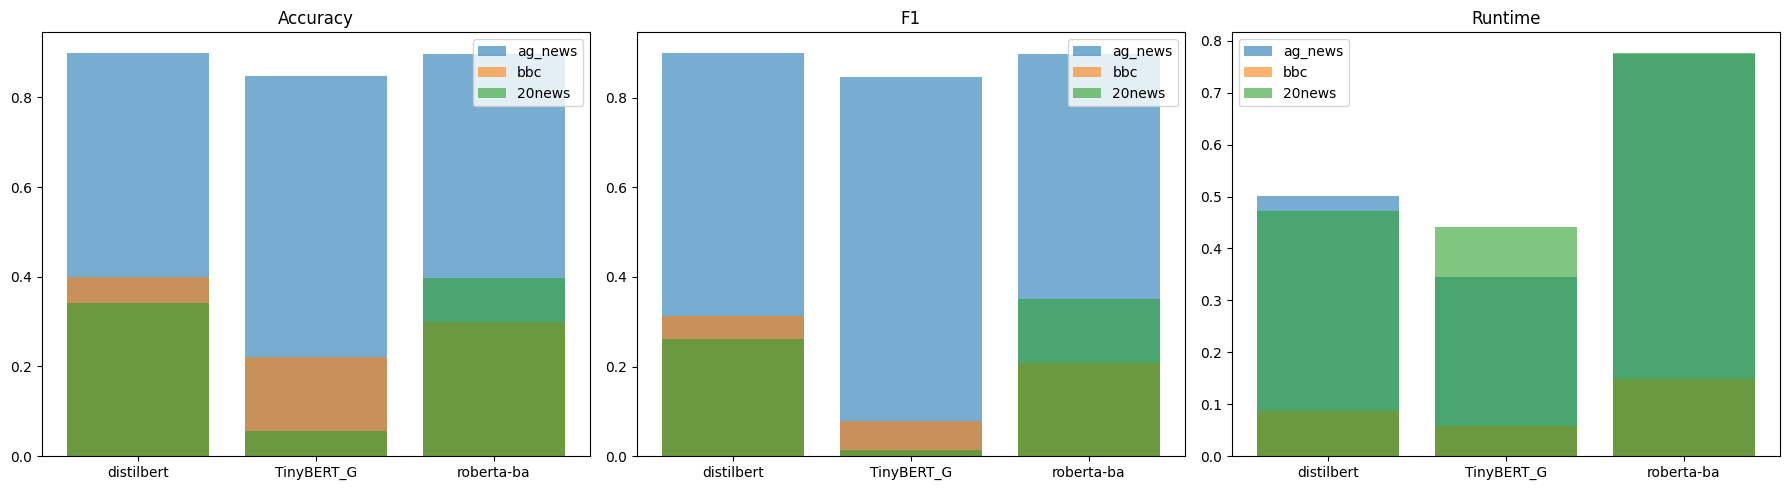

In [45]:
import matplotlib.pyplot as plt

def plot_metrics(results):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    for ax, metric in zip(axes, ['eval_accuracy', 'eval_f1', 'eval_runtime']):
        for dataset_name, model_results in results.items():
            values = [m[metric] for m in model_results.values()]
            labels = [name.split('/')[-1][:10] for name in model_results.keys()]

            ax.bar(labels, values, alpha=0.6, label=dataset_name)
            ax.set_title(metric.split('_')[-1].capitalize())
            ax.legend()

    plt.tight_layout()
    plt.savefig("results.png")
    plt.show()

plot_metrics(results)

In [46]:
for dataset_name, model_results in results.items():
    print(f"\n=== Results for {dataset_name.upper()} ===")
    for model_name, metrics in model_results.items():
        print(f"\nModel: {model_name}")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")


=== Results for AG_NEWS ===

Model: distilbert-base-uncased
eval_loss: 0.3297
eval_accuracy: 0.9000
eval_f1: 0.9008
eval_runtime: 0.5005
eval_samples_per_second: 759.2260
eval_steps_per_second: 47.9510
epoch: 2.0000

Model: huawei-noah/TinyBERT_General_4L_312D
eval_loss: 0.4899
eval_accuracy: 0.8474
eval_f1: 0.8472
eval_runtime: 0.3457
eval_samples_per_second: 1099.3050
eval_steps_per_second: 69.4300
epoch: 2.0000

Model: roberta-base
eval_loss: 0.3438
eval_accuracy: 0.8974
eval_f1: 0.8985
eval_runtime: 0.7746
eval_samples_per_second: 490.5940
eval_steps_per_second: 30.9850
epoch: 2.0000

=== Results for BBC ===

Model: distilbert-base-uncased
eval_loss: 1.4902
eval_accuracy: 0.4000
eval_f1: 0.3136
eval_runtime: 0.0868
eval_samples_per_second: 576.2830
eval_steps_per_second: 46.1030
epoch: 2.0000

Model: huawei-noah/TinyBERT_General_4L_312D
eval_loss: 1.6066
eval_accuracy: 0.2200
eval_f1: 0.0793
eval_runtime: 0.0576
eval_samples_per_second: 868.2850
eval_steps_per_second: 69.4630
epoc